# Tutorial

Let's work through an example of single-cell data analysis using Uncurl, using many of its features. For a much briefer example using the same dataset, see `examples/zeisel_subset_example.py`.

In [42]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import uncurl

## Loading data

In [2]:
data = scipy.io.loadmat('data/GSE60361_dat.mat')

This dataset is a subset of the data from Zeisel et al. 2015 (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE60361), consisting of mouse brain cells.

In [3]:
X = data['Dat']
X.shape

(19971, 753)

Here, X is a 2d numpy array containing read count data. It contains 753 cells and 19971 genes.

## Gene subset selection

Before doing anything else, we usually select a subset of about 20% of the genes. This is done using the `max_variance_genes` function, which first bins the genes by their mean expression values, and for each bin, selects the highest variance genes.

In [4]:
genes = uncurl.max_variance_genes(X, nbins=5, frac=0.2)
len(genes)

3990

Here, we divide the genes into five bins by their mean expression value, and in each bin, we select the top 20% of genes by variance. This gives us 3990 genes.

In [5]:
data_subset = X[genes,:]
data_subset.shape

(3990, 753)

## Distribution selection

Now, we can try determining which distribution fits the data best using the `DistFitDataset` function. This is a heuristic method that returns the fit errors for the Gaussian, Poisson, and Log-Normal distributions for each gene.

Based on our results, the Poisson distribution will be best for count (UMI) data, while the Log-Normal distribution will be a better fit for transformed (TPM, etc.) data. So it's okay to skip this step if you have a good sense of the data you're working with.

In [6]:
from uncurl import fit_dist_data
fit_errors = fit_dist_data.DistFitDataset(data_subset)

In [7]:
poiss_errors = fit_errors['poiss']
lognorm_errors = fit_errors['lognorm']
norm_errors = fit_errors['norm']

In [8]:
errors = np.vstack((poiss_errors, lognorm_errors, norm_errors))

In [9]:
print(sum(errors.argmax(0)==0))
print(sum(errors.argmax(0)==1))
print(sum(errors.argmax(0)==2))

1462
1732
796


This would indicate that the best fit distribution is the Log-Normal distribution, despite the data being UMI counts.

## State estimation

State estimation is the heart of UNCURL. This involves probabilistic matrix factorization and returns two matrices: `M`, a genes by clusters matrix indicating the "archetypal" cell for each cluster, and `W`, a clusters by cells matrix indicating the cluster assignments of each cell. State estimation requires the number of clusters to be provided beforehand. In this case, we know that there are 7 cell types.

The `run_state_estimation` is an interface to different state estimation methods for different distributions.

This step should finish in less than a couple of minutes.

In [14]:
M1, W1, ll = uncurl.run_state_estimation(data_subset, 7, dist='Poiss', disp=False)

In [15]:
M2, W2, cost = uncurl.run_state_estimation(data_subset, 7, dist='LogNorm')

## Clustering

The simplest way to do clustering is simply to take `W.argmax(0)`. This returns the most likely assigned cluster for each cell.

In [54]:
labels = W1.argmax(0)

## Visualization

It is recommended to run t-SNE on W, or M\*W. The Euclidean distance isn't really the best distance metric for W; usually cosine distance, L1 distance, or symmetric KL divergence work better, with KL divergence usually the best. However, as a custom distance metric it tends to be rather slow.

M\*W can be treated basically the same as the original data, and whatever visualization methods for the original data can also be used on it. However, given that M\*W is low-rank, taking the log might be necessary.

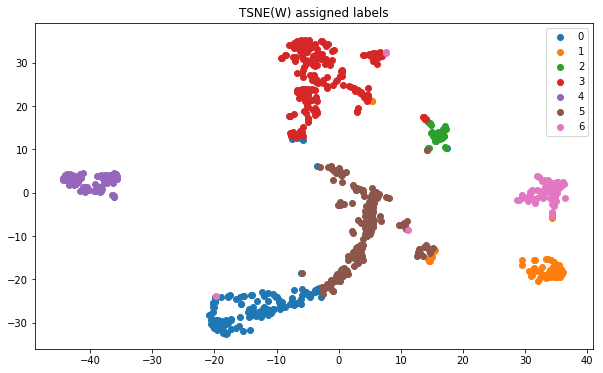

In [60]:
from sklearn.manifold import TSNE
from uncurl.sparse_utils import symmetric_kld

tsne = TSNE(2, metric=symmetric_kld)
tsne_w = tsne.fit_transform(W1.T)
fig = visualize_dim_red(tsne_w.T, labels, title='TSNE(W) assigned labels', figsize=(10,6))

Since we know the actual labels for the cell types, we can plot them here too:

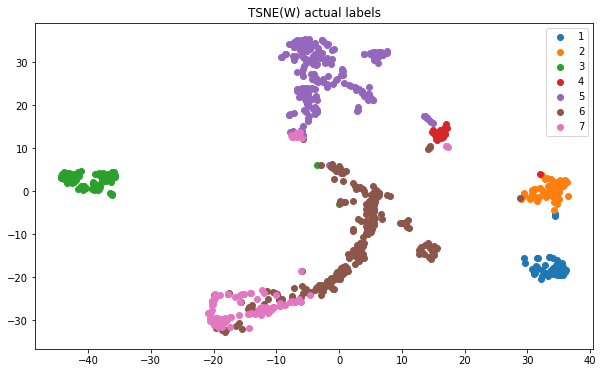

In [61]:
fig = visualize_dim_red(tsne_w.T, data['ActLabs'].flatten(), title='TSNE(W) actual labels', figsize=(10,6))

To use M\*W for visualization, we usually do some additional processing on it (as with t-SNE on the original dataset):

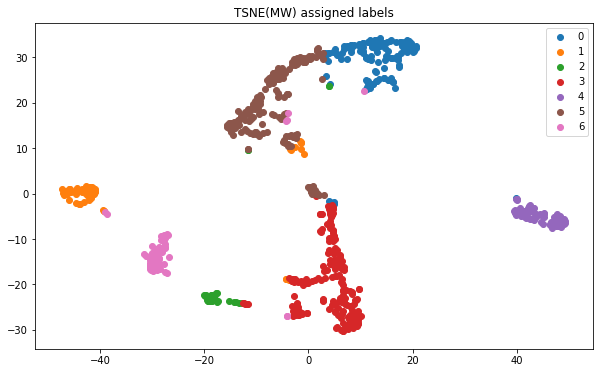

In [63]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(50)
tsne = TSNE(2)
mw = M1.dot(W1)
mw_log = np.log1p(mw)
mw_tsvd = tsvd.fit_transform(mw_log.T)
mw_tsne = tsne.fit_transform(mw_tsvd)
fig = visualize_dim_red(mw_tsne.T, labels, title='TSNE(MW) assigned labels', figsize=(10,6))

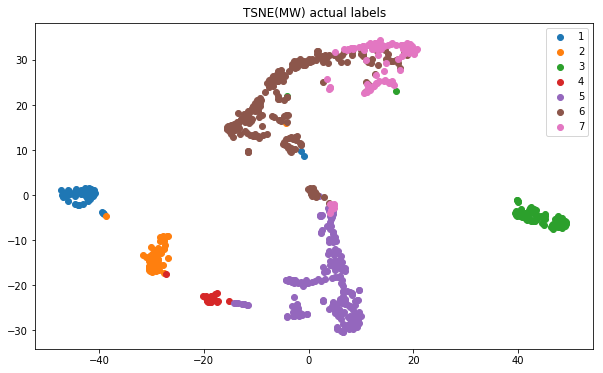

In [65]:
fig = visualize_dim_red(mw_tsne.T, data['ActLabs'].flatten(), title='TSNE(MW) actual labels', figsize=(10,6))

Another method for visualizing data is a MDS-based approach. This is fastest, but does not produce the most clean visualizations.

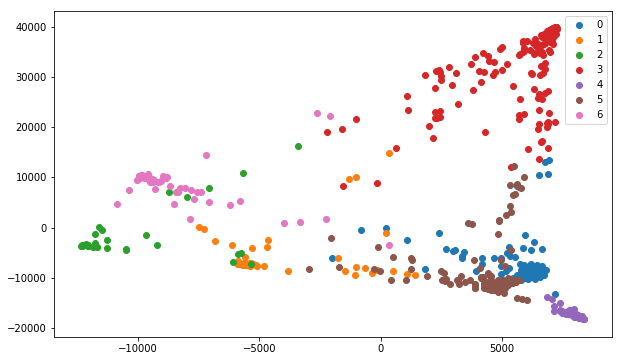

In [46]:
from uncurl.vis import visualize_dim_red
vis_mds = uncurl.mds(M1, W1, 2)
fig = visualize_dim_red(vis_mds, labels, figsize=(10,6))